In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from lib.DrugUtil import flatten, DrugUtil
import matplotlib.pyplot as plt

import plotly.express as px
from lib.FhirDataUtil import FhirDataUtil
from lib.CCSDataUtil import CCSDataUtil

def printmd(string):
    display(string)

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

_fhir_conditions_file = "input/fhir_conditions_20221003.csv"
_fhir_medications_file = "input/fhir_medications_20221003.csv"
_fhir_medications_ref_file = "input/fhir_medications_references_20221003.csv"
_fhir_demographics_file = "input/fhir_demographics_20221113.csv"
_output_dir = 'output/'

_rxnorm_file = "input_static/RxTerms202203/RxTerms202203.txt"
_rxnorm_ingredients_file = "input_static/RxTerms202203/RxTermsIngredients202203.txt"
_rxclass_file = "input_static/_rxclass_2022-04-10.csv"

_ccs_demographics_file = "input/ccs_demographics.csv"
_ccs_medications_file = "input/ccs_medications.csv"
_ccs_conditions_file = "input/ccs_conditions.csv"

_pc_demographics_file = "input/pcornet/demographic_fhir.csv"
_pc_medications_file = "input/pcornet/med_adm_fhir.csv"


In [2]:
drugUtil = DrugUtil()
drugUtil.load(rxnorm_file=_rxnorm_file,
                        rxnorm_ingredients_file=_rxnorm_ingredients_file, 
                        rxclass_file=_rxclass_file)

fhirUtil = FhirDataUtil()
ccsUtil = CCSDataUtil(drugUtil)

fhirUtil.load_conditions(fhir_conditions_file=_fhir_conditions_file, remove_health_concerns=True)
fhirUtil.load_demographics(fhir_demographics_file=_fhir_demographics_file)

ccsUtil.load_conditions(ccs_conditions_file= _ccs_conditions_file)
ccsUtil.load_demographics(_ccs_demographics_file)


Reading rxclass file...
Reading rxnorm file...
RAW FHIR conditions: 52621
FHIR conditions after pre-processing: 37248


/app/lib/CCSDataUtil.py:13: DtypeWarning: Columns (5,6,11,12,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.conditions = pd.read_csv(ccs_conditions_file, delimiter=',')
/app/lib/CCSDataUtil.py:75: DtypeWarning: Columns (11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  self.demographics = pd.read_csv(ccs_demographics)


Loaded CCS conditions records: 94735
Loaded demographics file with entries:  98877


In [3]:
snomed = fhirUtil.conditions[fhirUtil.conditions['coding_system'] == 'SNOMED']
print(f'Number of snomeds: {len(snomed)}')
icd10 = fhirUtil.conditions[fhirUtil.conditions['coding_system'] == 'ICD10']
print(f'Number of ICD10s: {len(icd10)}')


Number of snomeds: 19850
Number of ICD10s: 17398


In [4]:
pc_cond = pd.read_csv('input/pcornet/diagnosis_fhir.csv')
print('PCORNet Conditions: ', len(pc_cond))
pc_cond['dx_date_d'] = pd.to_datetime(pc_cond['dx_date'], format="%d%b%Y", errors="coerce").fillna(pd.to_datetime(pc_cond['admit_date'], format="%d%b%Y", errors="coerce"))
# fhir_enc_raw['start_d'] = pd.to_datetime(fhir_enc_raw['start'], format="%Y-%m-%dT%H:%M:%SZ", errors="coerce").fillna(pd.to_datetime(fhir_enc_raw['start'], format="%Y-%m-%d", errors="coerce"))

pc_demo = pd.read_csv('input/pcornet/demographic_fhir.csv')

PCORNet Conditions:  120358


/tmp/ipykernel_233/1985917506.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  pc_cond = pd.read_csv('input/pcornet/diagnosis_fhir.csv')


In [5]:
xls = pd.ExcelFile('input/chart_review/Chart_Review1.0.xlsx')
cr_cond_raw = pd.read_excel(xls, 'Diagnostic Codes')
cr_demo = pd.read_excel(xls, 'users_to_query')
cr_cond = cr_cond_raw.copy()
cr_cond['date_entered_d'] = pd.to_datetime(cr_cond['date_entered'], errors='coerce')

/usr/local/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [6]:
fhir_cond = icd10
fhir_demo = fhirUtil.demographics
ccs_cond = ccsUtil.conditions
ccs_demo = ccsUtil.demographics

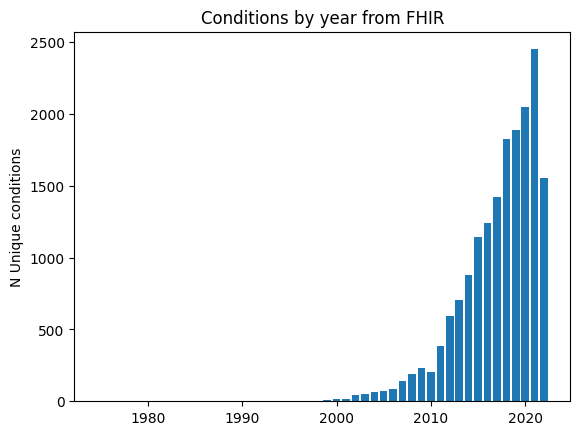

8596    1975-01-01
28234   1989-01-01
8573    1990-01-01
8594    1990-01-01
12133   1992-12-02
           ...    
5867    2022-09-09
51607   2022-09-10
4516    2022-09-12
34529   2022-09-12
26888   2022-09-12
Name: recordeddate_d, Length: 17255, dtype: datetime64[ns]

In [30]:
years = fhir_cond['recordeddate_d'].dt.year.value_counts().reset_index(name="Conditions")
plt.bar(years['index'], years['Conditions'])
plt.title('Conditions by year from FHIR')
plt.ylabel('N Unique conditions')
plt.show()
fhir_cond['recordeddate_d'].dropna().sort_values()


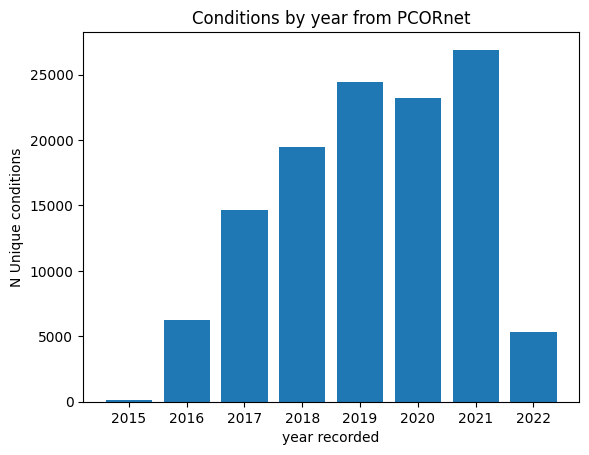

45920   2015-11-27
55052   2015-11-30
55060   2015-11-30
55074   2015-11-30
92863   2015-11-30
           ...    
70972   2022-04-07
1253    2022-04-08
1247    2022-04-08
1262    2022-04-08
96106   2022-04-09
Name: dx_date_d, Length: 120358, dtype: datetime64[ns]

In [31]:
years = pc_cond['dx_date_d'].dt.year.value_counts().reset_index(name="Conditions")
plt.bar(years['index'], years['Conditions'])
plt.title('Conditions by year from PCORnet')
plt.ylabel('N Unique conditions')
plt.xlabel('year recorded')
plt.show()
pc_cond['dx_date_d'].dropna().sort_values()



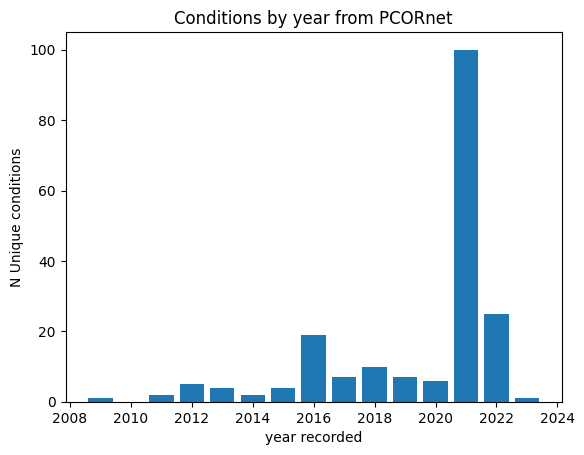

41    2009-07-29
279   2011-06-07
232   2011-06-07
276   2012-01-24
281   2012-01-24
229   2012-01-24
228   2012-01-24
205   2012-10-04
76    2013-04-08
40    2013-04-22
187   2013-08-05
186   2013-08-05
38    2014-01-27
188   2014-03-13
9     2015-02-03
8     2015-02-03
7     2015-02-03
14    2015-03-26
226   2016-01-13
259   2016-01-13
256   2016-01-13
247   2016-01-13
206   2016-01-20
255   2016-02-01
236   2016-02-01
235   2016-02-01
231   2016-02-01
278   2016-02-01
290   2016-02-01
1     2016-03-27
0     2016-03-27
264   2016-05-03
240   2016-05-03
241   2016-05-03
268   2016-05-03
265   2016-05-09
244   2016-05-09
111   2017-03-07
112   2017-03-29
113   2017-04-18
233   2017-06-05
266   2017-06-05
114   2017-06-20
175   2017-09-22
11    2018-03-07
12    2018-03-07
13    2018-03-07
2     2018-04-06
3     2018-04-06
152   2018-06-05
154   2018-06-05
153   2018-06-05
234   2018-09-05
271   2018-09-05
15    2019-02-04
37    2019-03-12
44    2019-03-12
39    2019-05-07
222   2019-09-

In [38]:
years = cr_cond['date_entered_d'].dt.year.value_counts().reset_index(name="Conditions")
plt.bar(years['index'], years['Conditions'])
plt.title('Conditions by year from PCORnet')
plt.ylabel('N Unique conditions')
plt.xlabel('year recorded')
plt.show()
cr_cond['date_entered_d'].sort_values()

In [39]:
start_date = '2015-11-27'
end_date = '2022-04-01'
print(f'Filtering for dates...')
print(f'Before (FHIR, PCORnet) ', len(fhir_cond), ' ', len(pc_cond))
fhir_cond = fhir_cond[fhir_cond['recordeddate'].between(start_date, end_date)]
pc_cond = pc_cond[pc_cond['dx_date_d'].between(start_date, end_date)]
print(f'After (FHIR, PCORnet) ', len(fhir_cond), ' ', len(pc_cond))


Filtering for dates...
Before (FHIR, PCORnet)  17398   120358
After (FHIR, PCORnet)  11614   120310


# Common Users

In [40]:
print("Comparision of FHIR to PC")
common_users = fhir_demo.drop_duplicates("user_id").merge(pc_demo.drop_duplicates("user_id"), on="user_id", how="outer", indicator="demo_merge1")
print(common_users['demo_merge1'].value_counts())
common_users = common_users[common_users['demo_merge1'] == 'both']

Comparision of FHIR to PC
left_only     844
both          618
right_only     11
Name: demo_merge1, dtype: int64


# Filter FHIR users (run if want to look at subset)

In [41]:
site_config = {
    'UCSFHEALTHPARTN': 'openepic_shared_ucsf_health',
    'UT1PARTNER': 'openepic_shared_university_of_utah_healthcare',
    'NY1PARTNER': 'openepic_shared_nyu_langone_medical_center',
    'SH2PARTNER': 'openepic_shared_sutter_health',
    'OS2PARTNER': 'openepic_shared_ochsner_health_system',
    'MF1PARTNER': 'openepic_shared_montefiore_medical_center',
    'BA1PARTNER': 'openepic_shared_baylor_scott_white'
}
pc_cond['site'] = pc_cond['siteid']
pc_cond = pc_cond.replace({'site': site_config})

In [42]:
# get users common to both datasets
common_users_fp = fhir_demo.drop_duplicates("user_id").merge(pc_demo.drop_duplicates("user_id"), on='user_id', how="inner")

print('FHIR conditions all: ', len(fhir_cond), ' users:', len(fhir_cond.drop_duplicates("user_id")))
print('PCORNet conditions all: ', len(pc_cond), ' users:', len(pc_cond.drop_duplicates("user_id")))
fhir_cond_fp = fhir_cond[fhir_cond['user_id'].isin(common_users_fp['user_id'])]
pc_cond_fp = pc_cond[pc_cond['user_id'].isin(common_users_fp['user_id'])]
print("-------- KEEPING ONLY USERS IN BOTH DATASETS -------")
print('FHIR conditions all: ', len(fhir_cond_fp), ' users:', len(fhir_cond_fp.drop_duplicates("user_id")))
print('PCORNet conditions all: ', len(pc_cond_fp), ' users:', len(pc_cond_fp.drop_duplicates("user_id")))
print("-------- KEEPING ONLY SITES IN PCORNET -------")
fhir_cond_fp = fhir_cond_fp[fhir_cond_fp['provider'].isin(site_config.values())]
print('FHIR conditions all: ', len(fhir_cond_fp), ' users:', len(fhir_cond_fp.drop_duplicates("user_id")))
print("-------- KEEPING ONLY ONE SITE PER USER (PCORNET SITE) -------")
common_records = fhir_cond_fp.merge(pc_cond_fp, left_on=['provider', 'user_id'], right_on=['site', 'user_id'], how="inner")
fhir_cond_fp = fhir_cond_fp[fhir_cond_fp['resource_id'].isin(common_records['resource_id'])]
print('FHIR conditions all: ', len(fhir_cond_fp), ' users:', len(fhir_cond_fp.drop_duplicates("user_id")))


FHIR conditions all:  11614  users: 1073
PCORNet conditions all:  120310  users: 622
-------- KEEPING ONLY USERS IN BOTH DATASETS -------
FHIR conditions all:  6343  users: 571
PCORNet conditions all:  118328  users: 611
-------- KEEPING ONLY SITES IN PCORNET -------
FHIR conditions all:  5484  users: 510
-------- KEEPING ONLY ONE SITE PER USER (PCORNET SITE) -------
FHIR conditions all:  4987  users: 468


# Run Comparison Tables

In [50]:
comparison_config = [
    {
        'title': 'Diabetes', 
        'codes': ['E10','E11'], 
        'ccs_field': 'diabetes', 
        'ccs_yes': [1], 
        'ccs_no': [2]
    },
#     {
#         'title': 'Diabetes General', 
#         'codes': ['E08','E09','E10','E11','E13'], 
#         'ccs_field': 'diabetes', 
#         'ccs_yes': [1], 
#         'ccs_no': [2]
#     },
    {
        'title': 'Hypertension', 
        'codes': ['I10'], 
        'ccs_field': 'hbp', 
        'ccs_yes': [1], 
        'ccs_no': [2]
    },
#     {
#         'title': 'Hypertension General', 
#         'codes': ['I10', 'I11'], 
#         'ccs_field': 'hbp', 
#         'ccs_yes': [1], 
#         'ccs_no': [2]
#     },
    {
        'title': 'Myocardial Infarction',
        'codes': ['I21','I22','I24'],
        'ccs_field': 'heart_attack',
        'ccs_yes': [1], 'ccs_no': [2]
    },
#     {
#         'title': 'Myocardial Infarction General',
#         'codes': ['I20.0', 'I21', 'I22', 'I24', 'I25.2', 'I25.5'],
#         'ccs_field': 'heart_attack',
#         'ccs_yes': [1], 'ccs_no': [2]
#     },
    {
        'title': 'Coronary Artery Disease',
        'codes': ['I20','I21','I22','I23','I24','I25'],
        'ccs_field': 'blockages_in_your_coronary',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'Heart Failure',
        'codes': ['I50'],
        'ccs_field': 'chf',
        'ccs_yes': [1], 'ccs_no': [2]
    },
#     {
#         'title': 'Heart Failure General',
#         'codes': ['I11.0','I13.0','I50','I97.13'],
#         'ccs_field': 'chf',
#         'ccs_yes': [1], 'ccs_no': [2]
#     },
    {
        'title': 'Stroke',
        'codes': ['I63'],
        'ccs_field': 'stroke',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'AFib',
        'codes': ['I48'],
        'ccs_field': 'afib',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'Sleep Apnea',
        'codes': ['G47.3'],
        'ccs_field': 'sleep_apnea',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'COPD',
        'codes': ['J44'],
        'ccs_field': 'copd',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'Asthma',
        'codes': ['J45'],
        'ccs_field': 'asthma',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'Cancer',
        'codes': ['C'],
        'ccs_field': 'cancer',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'Immunodeficiency',
        'codes': ['D80', 'D81', 'D82', 'D83', 'D84', 'D70', 'O98.7', 'Z21', 'B20', 'B97.35'],
        'ccs_field': 'immunodeficiency',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'HIV',
        'codes': ['Z21', 'B20', 'B97.35', 'O98.7'],
        'ccs_field': 'HIV',
        'ccs_yes': [1], 'ccs_no': [2]
    },
    {
        'title': 'Anemia',
        'codes': ['D50','D51','D52','D53.0','D53.2','D53.9','D64.9'],
        'ccs_field': 'anemia',
        'ccs_yes': [1], 'ccs_no': [2]
    },
#     {
#         'title': 'Anemia General',
#         'codes': ['D46.0','D46.1','D46.4','D46.2','D50','D51','D52','D53.0','D53.2','D53.9','D58.9','D59','D61','D55','D63','D64.9', 'D64.81', 'D64.1', 'D64.2'],
#         'ccs_field': 'anemia',
#         'ccs_yes': [1], 'ccs_no': [2]
#     }
]
# ['diabetes', 'hbp', 'blockages_in_your_coronary', 'heart_attack', 'chf', 'stroke', 'afib', 'sleep_apnea', 'copd', 'asthma', 'cancer', 'immunodeficiency', 'HIV', 'anemia', 'pregnant']



In [51]:
# SELECT GROUPS YOU WANT TO COMPARE
site = list(site_config.values())[0]
print(site)
# fhir_cond_d = fhir_cond[fhir_cond['user_id'].isin(common_users['user_id'])]
fhir_cond_d = fhir_cond_fp[fhir_cond_fp['provider'] == site]
# pc_cond_d = pc_cond[pc_cond['user_id'].isin(common_users['user_id'])]
pc_cond_d = pc_cond_fp[pc_cond_fp['site'] ==  site]
# ccs_cond_d = ccs_cond
common_users_d = fhir_demo.drop_duplicates('user_id').merge(pc_demo.drop_duplicates('user_id'), on='user_id', how="inner").drop_duplicates('user_id')
fhir_cond_d = fhir_cond_d.drop_duplicates(['user_id', 'coding_code'])
pc_cond_d = pc_cond_d.drop_duplicates(['user_id', 'dx'])
# site


openepic_shared_ucsf_health


In [46]:
# fv = fhir_cond_d['user_id'].value_counts().reset_index(name='count_fhir')
# fv = fv.rename(columns={'index': 'user_id'})
# pv = pc_cond_d['user_id'].value_counts().reset_index(name='count_pc')
# pv = pv.rename(columns={'index': 'user_id'})
# m = fv.merge(pv, on='user_id', how='outer', indicator="_merge")
# m

In [47]:
# For Query
# fhir_cond_d[fhir_cond_d['user_id'] == 35829]
# pc_cond_d[pc_cond_d['user_id'] == 458871]

In [48]:
# For Query
# pc_cond_d[pc_cond_d['user_id'] == 35829]

In [49]:
def compare(ccs_cond, 
                     fhir_cond, 
                     pc_cond, 
                     search_icd10_codes, 
                     common_users,
                     ccs_field, 
                     ccs_yes_values=[1], 
                     ccs_no_values=[2], 
                     condition_title=None, 
                     verbose=True):
    fhir_filter = fhir_cond['coding_code'].str.startswith(tuple(search_icd10_codes))
    fhir_cond_s = fhir_cond[fhir_filter].drop_duplicates("user_id")

    
    pc_filter = pc_cond['dx'].str.startswith(tuple(search_icd10_codes))
    pc_cond_s = pc_cond[pc_filter].drop_duplicates("user_id")
    
    ccs_filter = ccs_cond[ccs_field].isin(ccs_yes_values)
    ccs_cond_s = ccs_cond[ccs_filter].drop_duplicates('user_id')
    
    fp_all = fhir_cond_s.merge(pc_cond_s, on="user_id", how="inner")
    
    fp_any = pd.concat([fhir_cond_s['user_id'], pc_cond_s['user_id']]).drop_duplicates()
    
    fp_none = common_users[~common_users['user_id'].isin(fp_any)]
    
    return { 
        'fhir_only': len(fhir_cond_s) - len(fp_all),
        'pc_only': len(pc_cond_s) - len(fp_all),
        'fp_all': len(fp_all),
        'fp_any': len(fp_any),
        'fp_none': len(fp_none),
        'fhir': len(fhir_cond_s),
        'pc': len(pc_cond_s),
            
            
    }

# fhir_cond_c = fhir_cond[fhir_cond['user_id'].isin(common_users_fp['user_id'])].drop_duplicates(['user_id', 'coding_code'])
# pc_cond_c = pc_cond[pc_cond['user_id'].isin(common_users_fp['user_id'])].drop_duplicates(['user_id', 'dx'])
# ccs_cond_c = ccs_cond[ccs_cond['user_id'].isin(common_users['user_id'])]
print("test run...")
compare(ccs_cond_d, fhir_cond_d, pc_cond_d, ['E10', 'E11'], common_users, 'diabetes', [1], [2])
    

test run...


NameError: name 'ccs_cond_d' is not defined

In [28]:
result = []
for config in comparison_config:
    print('Processing ', config['title'])
    comp = compare(ccs_cond_d, fhir_cond_d, pc_cond_d, config['codes'], common_users_d, config['ccs_field'], [1], [2])
    comp['fp_any'] = comp['fp_any'] if comp['fp_any'] != 0 else 0.01
    resultRow = {
                'Diagnosis Group': config['title'],
                'FHIR Only': str(comp['fhir_only']) + ' (' + str(round((comp['fhir_only']*100)/len(common_users))) + '%)',
#                 '% Capture': str(round(comp['fhir']*100 / comp['fp_any'])) + '%',
                'PCORnet Only': str(comp['pc_only']) + ' (' + str(round((comp['pc_only']*100)/len(common_users))) + '%)',
#                 '%_Capture': str(round(comp['pc']*100 / comp['fp_any'])) + '%',
                'Both': str(comp['fp_all']) + ' (' + str(round((comp['fp_all']*100)/len(common_users))) + '%)',
                'Neither': f"{comp['fp_none']} ({str(round((comp['fp_none']*100)/len(common_users)))}%)",
                'Present in Either, N': str(comp['fp_any']), #+ ' (' + str(round((comp['fp_any']*100)/len(common_users))) + '%)',
                'FHIR': f'{comp["fhir"]} ({round(comp["fhir"]*100/comp["fp_any"])}%)',
                'PCORnet': f'{comp["pc"]} ({round(comp["pc"]*100/comp["fp_any"])}%)'
                }
    result.append(resultRow)
result = pd.DataFrame(result)

Processing  Diabetes
Processing  Hypertension
Processing  Myocardial Infarction
Processing  Coronary Artery Disease
Processing  Heart Failure
Processing  Stroke
Processing  AFib
Processing  Sleep Apnea
Processing  COPD
Processing  Asthma
Processing  Cancer
Processing  Immunodeficiency
Processing  HIV
Processing  Anemia


In [29]:
print(f'     Diagnosis of {len(common_users_d)} patients with diagnosis present in:')
grey_columns = [c for c in result.columns if c.startswith('%')]
red_columns = ['Neither']
def highlight_cols(x):
    df = x.copy()
    df.loc[:, :] = 'background-color: none'
    df[grey_columns] = 'color: grey'
#     df[red_columns] = 'color: red'
    return df 
display(result.style.apply(highlight_cols, axis = None))

     Diagnosis of 618 patients with diagnosis present in:


,Diagnosis Group,FHIR Only,PCORnet Only,Both,Neither,"Present in Either, N",FHIR,PCORnet
0,Diabetes,0 (0%),8 (1%),4 (1%),606 (98%),12,4 (33%),12 (100%)
1,Hypertension,1 (0%),20 (3%),15 (2%),582 (94%),36,16 (44%),35 (97%)
2,Myocardial Infarction,0 (0%),0 (0%),0 (0%),618 (100%),0.01,0 (0%),0 (0%)
3,Coronary Artery Disease,0 (0%),5 (1%),5 (1%),608 (98%),10,5 (50%),10 (100%)
4,Heart Failure,0 (0%),4 (1%),0 (0%),614 (99%),4,0 (0%),4 (100%)
5,Stroke,0 (0%),2 (0%),0 (0%),616 (100%),2,0 (0%),2 (100%)
6,AFib,0 (0%),9 (1%),0 (0%),609 (99%),9,0 (0%),9 (100%)
7,Sleep Apnea,1 (0%),11 (2%),6 (1%),600 (97%),18,7 (39%),17 (94%)
8,COPD,0 (0%),1 (0%),1 (0%),616 (100%),2,1 (50%),2 (100%)
9,Asthma,0 (0%),8 (1%),5 (1%),605 (98%),13,5 (38%),13 (100%)


In [25]:
total_dx = pd.to_numeric(result['Present in Either, N'].str.split(' ', 1, expand=True)[0]).sum()
print('total diagnoses', total_dx)
fhir_dx = pd.to_numeric(result['FHIR'].str.split(' ', 1, expand=True)[0]).sum()
print('Sn of FHIR N', fhir_dx)
print('Sn of FHIR %', fhir_dx / total_dx)
pc_dx = pd.to_numeric(result['PCORnet'].str.split(' ', 1, expand=True)[0]).sum()
print('Sn of PC N', pc_dx)
print('Sn of PC %', pc_dx / total_dx)

pc_total = pd.to_numeric(result['PCORnet'].str.split(' ', 1, expand=True)[0])
pc_p = result['PCORnet'].str.split('(', 1, expand=True)
pc_p[1] = pd.to_numeric(pc_p[1].str[:2])
pc_p[0] = pd.to_numeric(pc_p[0])
pc_p.apply(lambda x: (x[0]*x[1])/100, axis=1).sum()
# pc_p[0].sum()

total diagnoses 35.04
Sn of FHIR N 14
Sn of FHIR % 0.3995433789954338
Sn of PC N 33
Sn of PC % 0.9417808219178082


/tmp/ipykernel_12/1088383994.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  total_dx = pd.to_numeric(result['Present in Either, N'].str.split(' ', 1, expand=True)[0]).sum()
/tmp/ipykernel_12/1088383994.py:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  fhir_dx = pd.to_numeric(result['FHIR'].str.split(' ', 1, expand=True)[0]).sum()
/tmp/ipykernel_12/1088383994.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  pc_dx = pd.to_numeric(result['PCORnet'].str.split(' ', 1, expand=True)[0]).sum()
/tmp/ipykernel_12/1088383994.py:10: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  pc_total = pd.to_numeric(result['PCORnet'].str.split(' ',

ValueError: Unable to parse string "0%" at position 2

In [50]:
print("FHIR Mean Capture Rate: ", pd.to_numeric(result['% Capture'].str[:-1]).mean())
print("PCORNet Mean Capture Rate: ", pd.to_numeric(result['%_Capture'].str[:-1]).mean())
print("Mean FHIR codes per patient: ", fhir_cond_d.groupby('user_id').size().mean(), " std: ", fhir_cond_d.groupby('user_id').size().std())
print("Mean PCORNet codes per patient: ", pc_cond_d.groupby('user_id').size().mean(), " std: ", pc_cond_d.groupby('user_id').size().std())


KeyError: '% Capture'

In [170]:
fhir_cond_d.drop_duplicates("user_id").groupby("provider").size().sort_values(ascending=False).reset_index(name="count")['count'].sum()

488

600

In [121]:
pc_cond_fp['enc_type'].value_counts()

AV    74606
OA    22666
TH     8316
IP     4416
OS     3687
ED     2575
UN      754
EI      745
OT      398
NI      210
Name: enc_type, dtype: int64

In [189]:
pc_cond

,v1,user_id,diagnosisid,encounterid,enc_type,admit_date,dx,dx_type,dx_date,dx_source,pdx,datamartid,siteid,query_date,cdrn_facilityid,site
0,26,502639,{C21B53E3-3272-44D4-B1F8-78F25CC597AC},1038398261,OA,14jun2020,J31.0,10,14jun2020,FI,S,SUTTER,SH2PARTNER,14jun2022,NaN,openepic_shared_sutter_health
1,26,502639,{59185F2E-E7D9-46E3-A311-FAC5D67022FE},1136833765,OA,23nov2021,M79.18,10,23nov2021,FI,S,SUTTER,SH2PARTNER,14jun2022,NaN,openepic_shared_sutter_health
2,26,502639,{C9E93863-78D8-4CDC-90F5-D7C65E02D443},892747432,AV,19jan2018,Z23,10,19jan2018,FI,S,SUTTER,SH2PARTNER,14jun2022,NaN,openepic_shared_sutter_health
3,26,502639,{A5730640-15ED-411F-BD29-6181EB5C662D},936074887,AV,14sep2018,R92.2,10,14sep2018,FI,S,SUTTER,SH2PARTNER,14jun2022,NaN,openepic_shared_sutter_health
4,26,502639,{7F719426-21A7-463B-84F0-1A29012FF1C3},1072911350,OA,30dec2020,I49.9,10,30dec2020,FI,S,SUTTER,SH2PARTNER,14jun2022,NaN,openepic_shared_sutter_health
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120353,50165,554411,19578405,42933104,OA,25feb2022,M25.572,10,NaN,FI,S,C8NYU,NY1PARTNER,05jul2022,1.0,openepic_shared_nyu_langone_medical_center
120354,50165,554411,145129017,42763066,OA,26aug2019,R07.89,10,NaN,FI,S,C8NYU,NY1PARTNER,05jul2022,1.0,openepic_shared_nyu_langone_medical_center
120355,50165,554411,19595947,42933104,OA,25feb2022,M77.52,10,NaN,FI,S,C8NYU,NY1PARTNER,05jul2022,1.0,openepic_shared_nyu_langone_medical_center
120356,50165,554411,66140399,13494516,AV,09sep2019,E78.5,10,NaN,FI,S,C8NYU,NY1PARTNER,05jul2022,1.0,openepic_shared_nyu_langone_medical_center


# PcorNet

In [6]:
pc_cond = pd.read_csv('input/pcornet/diagnosis_fhir.csv')
pc_demo = pd.read_csv('input/pcornet/demographic_fhir.csv')

/var/folders/_n/j7wb5zn173d8t_tnxz9rb5p00000gn/T/ipykernel_10275/4266438744.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  pc_cond = pd.read_csv('input/pcornet/diagnosis_fhir.csv')


In [9]:
fhir_demo = fhirUtil.demographics.drop_duplicates(subset="user_id")
fhir_cond = fhirUtil.conditions[fhirUtil.conditions['coding_system'] == 'ICD10']

In [12]:
ccs_cond = ccsUtil.conditions

In [10]:
m_demo = pc_demo.drop_duplicates(subset="user_id").merge(fhir_demo.drop_duplicates(subset="user_id"), on="user_id", indicator=True, how="outer")
common_users = m_demo[m_demo['_merge'] == 'both']
m_demo['_merge'].value_counts()


right_only    844
both          618
left_only      11
Name: _merge, dtype: int64

In [69]:
print('Common total fhir users:', len(fhir_demo[fhir_demo['user_id'].isin(common_users['user_id'])].drop_duplicates('user_id')))
print('Common total pcornet users:', len(pc_demo[pc_demo['user_id'].isin(common_users['user_id'])].drop_duplicates('user_id')))
fhir_cond_pc = fhir_cond[fhir_cond['user_id'].isin(common_users['user_id'])]
pc_cond_fhir = pc_cond[pc_cond['user_id'].isin(common_users['user_id'])]
print('Common fhir users with conditions: ', len(fhir_cond_pc.drop_duplicates('user_id')))
print('Common Pcornet users with conditions:', len(pc_cond_fhir.drop_duplicates('user_id')))

Common total fhir users: 618
Common total pcornet users: 618
Common fhir users with conditions:  600
Common Pcornet users with conditions: 611


In [102]:
def compare(left, right, codes, left_field, right_field, verbose=True):
#         {
#         'title': 'Diabetes', 
#         'codes': ['E10','E11'], 
#         'ccs_field': 'diabetes', 
#         'ccs_yes': [1], 
#         'ccs_no': [2]
#     },
    
    left_filter = left[left_field].str.startswith(tuple(codes))
    left_s = left[left_filter].drop_duplicates(subset='user_id')
    left_no_s = common_users[~common_users["user_id"].isin(left_s['user_id'])].drop_duplicates(subset='user_id')
    
    right_filter = right[right_field].str.startswith(tuple(codes))
    right_s = right[right_filter].drop_duplicates(subset="user_id")
    right_no_s = common_users[~common_users["user_id"].isin(right_s['user_id'])].drop_duplicates(subset='user_id')
    
    m = left_s.merge(right_s, on="user_id", how="outer", indicator=True)
    
    left_no_s.drop('_merge', axis=1, inplace=True)
    right_no_s.drop('_merge', axis=1, inplace=True)
    m_no = left_no_s.merge(right_no_s, on="user_id", how="outer", indicator=True)
    
    both_positive = m[m['_merge']=='both']
    left_only = m[m['_merge'] == 'left_only']
    right_only = m[m['_merge'] == 'right_only']
    
    both_negative = m_no[m_no['_merge'] == 'both']
    
    r = {
        'both_len': len(both_positive),
        'left_only_len': len(left_only),
        'right_only_len': len(right_only),
        'both_negative_len': len(both_negative),
        'total_yes': len(both_positive)+len(left_only)+len(right_only),
        'total_no': len(left_only)+len(right_only)+len(both_negative)
    }
    return r
    
    
result = []
for config in comparison_config:
    print('Processing ', config['title'])
    comp = compare(
                               left=fhir_cond_pc,
                               right=pc_cond_fhir,
                               codes=config['codes'], 
                               left_field= 'coding_code',
                               right_field='dx',
                               verbose=False)

    resultRow = {
    'title': config['title'],
    'Both Pos': comp['both_len'],
    'CF %': round((comp['both_len']*100)/comp['total_yes']),
    'FHIR Pos': comp['left_only_len'],
    'C %': round((comp['left_only_len']*100)/comp['total_yes']),
    'PCORNET Pos': comp['right_only_len'],
    'F %': round((comp['right_only_len']*100)/comp['total_yes']),
    'Both Negative': comp['both_negative_len'],
    'BN %': round((comp['both_negative_len']*100)/(comp['total_no']))
    }
    result.append(resultRow)
result_df = pd.DataFrame(result)

grey_columns = ['CF %', 'F %', 'C %', 'BN %']
red_columns = ['FHIR Pos', 'PCORNET Pos']
green_columns = ['Both Pos', 'Both Negative']
def highlight_cols(x):
    df = x.copy()
    df.loc[:, :] = 'background-color: none'
    df[grey_columns] = 'color: grey'
    df[red_columns] = 'color: red'
    df[green_columns] = 'color: green'
    return df 
display(result_df.style.apply(highlight_cols, axis = None))

# result_df


Processing  Diabetes
Processing  Diabetes General
Processing  Hypertension
Processing  Hypertension General
Processing  Myocardial Infarction
Processing  Myocardial Infarction General
Processing  Coronary Artery Disease
Processing  Heart Failure
Processing  Heart Failure General
Processing  Stroke
Processing  AFib
Processing  Sleep Apnea
Processing  COPD
Processing  Asthma
Processing  Cancer
Processing  Immunodeficiency
Processing  HIV
Processing  Anemia
Processing  Anemia General


,title,Both Pos,CF %,FHIR Pos,C %,PCORNET Pos,F %,Both Negative,BN %
0,Diabetes,46,56,11,13,25,30,536,94
1,Diabetes General,47,57,10,12,25,30,536,94
2,Hypertension,161,65,33,13,52,21,372,81
3,Hypertension General,161,65,33,13,54,22,370,81
4,Myocardial Infarction,3,23,5,38,5,38,605,98
5,Myocardial Infarction General,6,27,5,23,11,50,596,97
6,Coronary Artery Disease,31,47,6,9,29,44,552,94
7,Heart Failure,9,39,1,4,13,57,595,98
8,Heart Failure General,9,39,1,4,13,57,595,98
9,Stroke,2,29,2,29,3,43,611,99


In [70]:
# Check dataset
fhir_cond_pc
pc_cond_fhir

,v1,user_id,diagnosisid,encounterid,enc_type,admit_date,dx,dx_type,dx_date,dx_source,pdx,datamartid,siteid,query_date,cdrn_facilityid
0,26,502639,{C21B53E3-3272-44D4-B1F8-78F25CC597AC},1038398261,OA,14jun2020,J31.0,10,14jun2020,FI,S,SUTTER,SH2PARTNER,14jun2022,NaN
1,26,502639,{59185F2E-E7D9-46E3-A311-FAC5D67022FE},1136833765,OA,23nov2021,M79.18,10,23nov2021,FI,S,SUTTER,SH2PARTNER,14jun2022,NaN
2,26,502639,{C9E93863-78D8-4CDC-90F5-D7C65E02D443},892747432,AV,19jan2018,Z23,10,19jan2018,FI,S,SUTTER,SH2PARTNER,14jun2022,NaN
3,26,502639,{A5730640-15ED-411F-BD29-6181EB5C662D},936074887,AV,14sep2018,R92.2,10,14sep2018,FI,S,SUTTER,SH2PARTNER,14jun2022,NaN
4,26,502639,{7F719426-21A7-463B-84F0-1A29012FF1C3},1072911350,OA,30dec2020,I49.9,10,30dec2020,FI,S,SUTTER,SH2PARTNER,14jun2022,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120339,48641,547213,842348168,UTAH10581382,AV,10aug2017,Z00.00,10,NaN,FI,P,C4UU,UT1PARTNER,13jun2022,NaN
120340,48641,547213,548738098,UTAH11794463,AV,18dec2017,J01.00,10,NaN,FI,P,C4UU,UT1PARTNER,13jun2022,NaN
120341,48641,547213,25928655,UTAH10581382,AV,10aug2017,Z12.4,10,NaN,FI,S,C4UU,UT1PARTNER,13jun2022,NaN
120342,48641,547213,873757065,UTAH21035279,AV,03mar2021,Z23,10,NaN,FI,P,C4UU,UT1PARTNER,13jun2022,NaN


In [93]:
pc_users = pc_cond_fhir[pc_cond_fhir['dx'].str.startswith(('E10', 'E11'))].drop_duplicates(subset="user_id")
fhir_users = fhir_cond_pc[fhir_cond_pc['coding_code'].str.startswith(('E10', 'E11'))].drop_duplicates(subset="user_id")

In [96]:
len(fhir_users[~fhir_users['user_id'].isin(pc_users['user_id'])])

11

In [87]:
len(common_users[~common_users['user_id'].isin((*pc_users, *fhir_users))])

536

In [103]:
len([1647, 16853, 102891, 117086, 200552, 302382, 324260, 324726, 324961, 331019, 331110, 331135, 331300, 331450, 331467, 331515, 331920, 333749, 344968, 357029, 383858, 386617, 387173, 387417, 388923, 389802, 395485, 395659, 395756, 397160, 399087]
)

31